# Work Area

This Jupyter notebook is used to test small snippets of code - mainly for publishing on the [website blog](https://paulknewton.github.io/covid-ml/blog).

In [1]:
!curl -O https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  456k  100  456k    0     0   964k      0 --:--:-- --:--:-- --:--:--  964k


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_excel("COVID-19-geographic-disbtribution-worldwide.xlsx").set_index("dateRep")

In [5]:
df

,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
dateRep,,,,,,,,,
2020-04-14,14,4,2020,58,3,Afghanistan,AF,AFG,37172386.0
2020-04-13,13,4,2020,52,0,Afghanistan,AF,AFG,37172386.0
2020-04-12,12,4,2020,34,3,Afghanistan,AF,AFG,37172386.0
2020-04-11,11,4,2020,37,0,Afghanistan,AF,AFG,37172386.0
2020-04-10,10,4,2020,61,1,Afghanistan,AF,AFG,37172386.0
...,...,...,...,...,...,...,...,...,...
2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0
2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0


In [10]:
df.describe()[["cases", "deaths"]]

,cases,deaths
count,10742.000000,10742.000000
mean,174.386986,11.064420
std,1324.174058,87.270702
min,-9.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,17.000000,0.000000
max,35527.000000,2087.000000


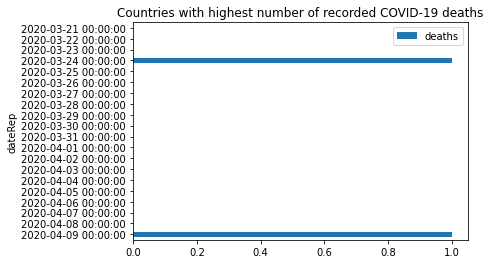

In [8]:
# using dataframe.plot
df[df["countriesAndTerritories".tail(20).plot(kind="barh", y=["deaths"], title="Countries with highest number of recorded COVID-19 deaths")

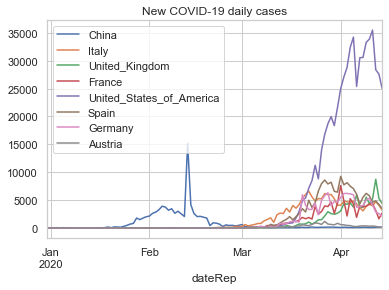

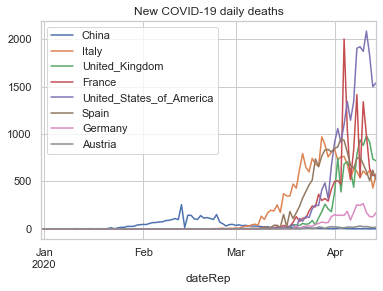

In [44]:
# Derivative of COVID-19 cases (unscaled) i.e. new cases/days
# Selected countries merged on to 1 plot

# cases
df_all = pd.DataFrame()
for c in countries:
    # no need to transform, just sort on date
    df_all[c] = df[df["countriesAndTerritories"] == c]["cases"].sort_index()
ax = df_all.plot(title="New COVID-19 daily cases")
ax.legend(df_all.columns)
fig.tight_layout()
plt.savefig("docs/covid_daily_cases.png")

# deaths
df_all = pd.DataFrame()
for c in countries:
    df_all[c] = df[df["countriesAndTerritories"] == c]["deaths"].sort_index()
ax = df_all.plot(title="New COVID-19 daily deaths")
ax.legend(df_all.columns)
fig.tight_layout()
#plt.savefig("docs/covid_daily_deaths.png")

### Remarks
These graphs show the rise of the virus over its lifetime. The peak of each curve is when the virus is spreading fastest through a population. The fall of the curve is when the virus is slowing down and reaching the end of its spread.

* These derivative curves show more clearly the rate at which the virus is spreading. Temporary decreases often give offer a false hope and the infection rate soon returns to previously higher levels. This may be due to changes in the spread of the virus, delayed reporting of cases over weekends etc.

* The shape of the curve generally follows a bell-curve shape, but there is concern that the peak starts to plateau over a prolonged period before dropping. However, the virus appears to be clearly slowing down in some countries (e.g. Austria).

* There is a fear over the longer term that the infection rate may rise again as social distancing measures are relaxed (a so-called "2nd wave").

## Country-specific daily infections and deaths

These graphs show how daily rates of deaths vary over time for selected countries.

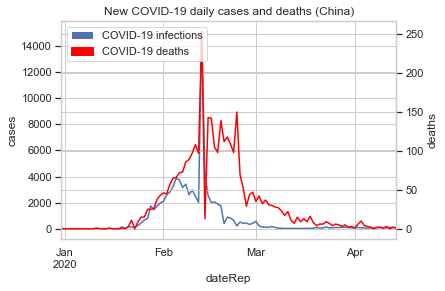

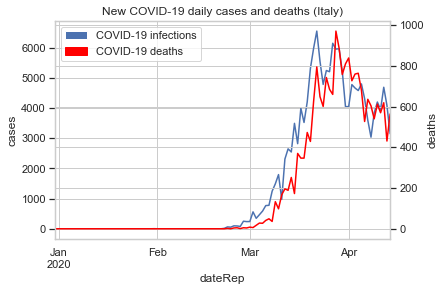

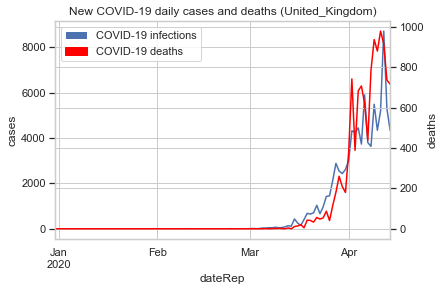

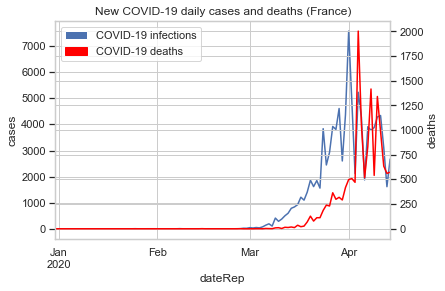

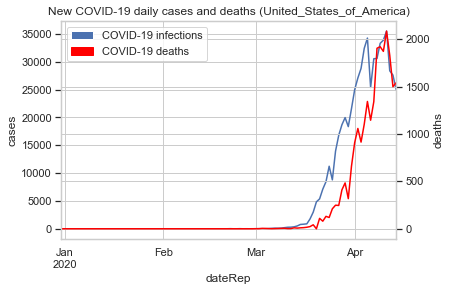

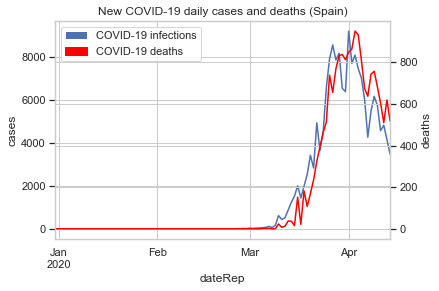

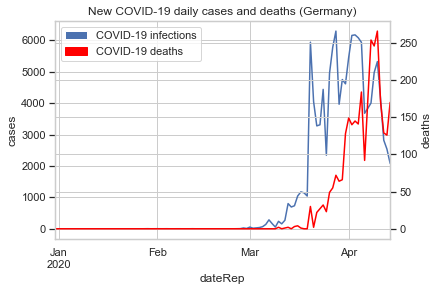

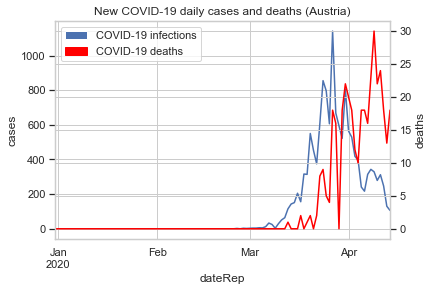

In [45]:
# Derivative of COVID-19 cases (unscaled) i.e. new cases/days
# 1 graph per country. Cases and deaths plotted on separate y-axes
for c in countries:
    # no need to transform, just sort on date
    ax_cases = df[df["countriesAndTerritories"] == c].sort_index().plot(y="cases", legend=False)
    ax_deaths = ax_cases.twinx()
    ax_deaths = df[df["countriesAndTerritories"] == c].sort_index().plot(y="deaths", color="red", ax=ax_deaths)
    
    ax_cases.set_title("New COVID-19 daily cases and deaths (%s)" % c)
    ax_cases.set_ylabel("cases")
    ax_deaths.set_ylabel("deaths")
    plt.legend(handles=[mpatches.Patch(label="COVID-19 infections"), mpatches.Patch(color="red", label="COVID-19 deaths")], loc=2)
    #plt.savefig("docs/new_cases_deaths_%s.png" % c)

### Remarks
* The rates of increase/decrease in new COVID-19 infections and deaths have very similar rates. The curves for countries such as Italy and the United States show clearly how changes in death rates lag the infection rates: peaks in the daily infection rate lead to peaks in the daily recorded deaths some days later.

---
# Unused

Text(0, 0.5, 'deaths')

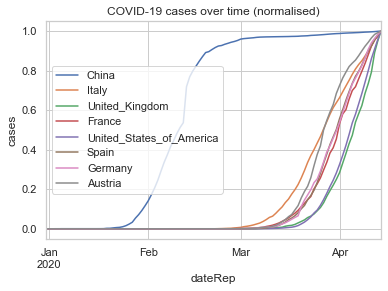

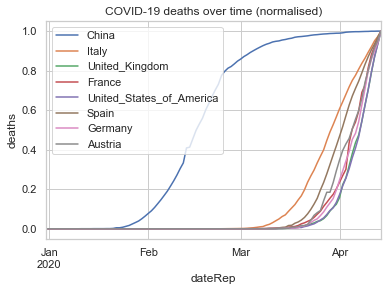

In [46]:
# COVID-19 cases for selected countries (normalise 0-1)
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

ax_cases = None
ax_deaths = None

# extract data for each country
for c in countries:
    df_c = df[df["countriesAndTerritories"] == c][["cases", "deaths"]].sort_index().cumsum()
    
    # normalise the values 0-1
    np_scaled = min_max_scaler.fit_transform(df_c)
    df_c_normalized = pd.DataFrame(np_scaled, columns=df_c.columns, index=df_c.index)
    
    ax_cases = df_c_normalized.plot(ax=ax_cases, y="cases", title="COVID-19 cases over time (normalised)")
    ax_deaths = df_c_normalized.plot(ax=ax_deaths, y="deaths", title="COVID-19 deaths over time (normalised)")

ax_cases.legend(countries)
ax_cases.set_ylabel("cases")
ax_deaths.legend(countries)
ax_deaths.set_ylabel("deaths")

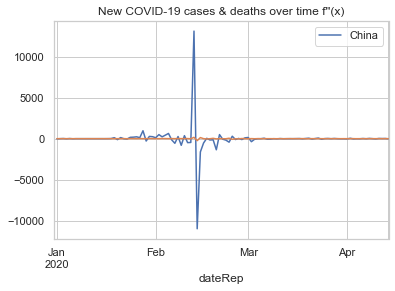

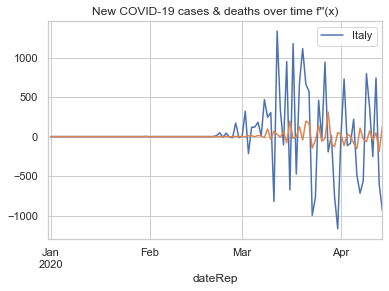

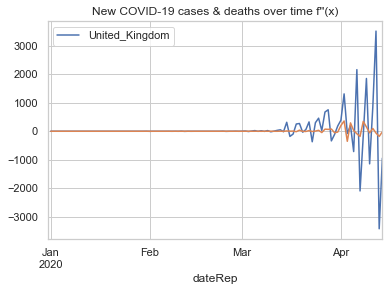

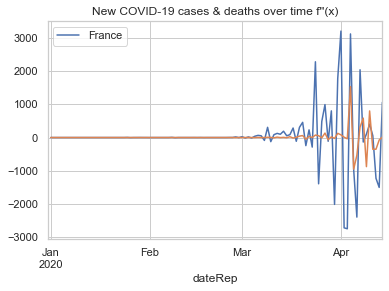

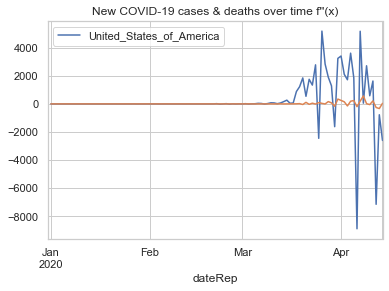

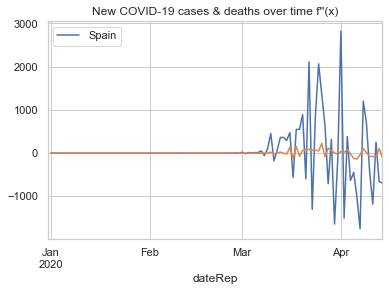

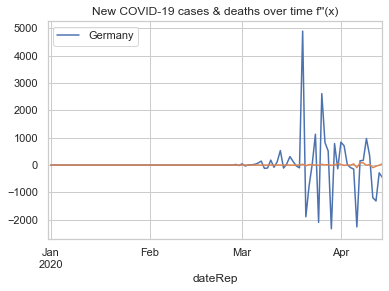

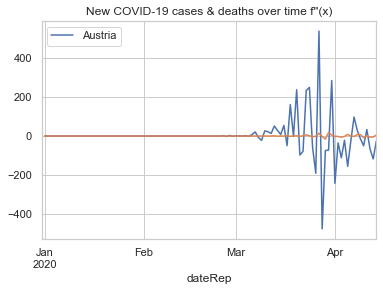

In [47]:
# 2nd derivative of COVID-19 cases (unscaled) i.e. new cases/days
# 1 graph per country
# Shows when the infection rates increase/decrease
ax = None
for c in countries:
    # transform daily delta into cumulative'
    ax = df[df["countriesAndTerritories"] == c][["cases", "deaths"]].sort_index().diff(axis=0).plot(title="New COVID-19 cases & deaths over time f''(x)")
    ax.legend([c])
    #plt.savefig("docs/graphs/covid_derivative2_%s.png" % c)